<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/WISDM_transformer_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

get_fram : 데이터 프레임 처리
DataFrame에서 특정 조건의 프레임 추출

### loss : nan 이슈 해결
문제의 원인은 모델 학습에 사용되는 훈련 데이터(x_train)와 검증 데이터(x_val)에 NaN (Not a Number) 값이 포함되어 있었기 때문

처음에 데이터를 로드하고 전처리할 때 dropna()를 사용했지만, 사용자별로 데이터를 분할한 후에 생성된 train_df, val_df, test_df 데이터프레임에 여전히 일부 NaN 값이 남아 있었습니다.

이렇게 NaN 값이 포함된 데이터프레임을 기반으로 segments 함수를 통해 윈도우 데이터를 생성하면서 x_train과 x_val에도 NaN 값이 전달되었고, 이 때문에 모델 학습 과정에서 손실 계산이 제대로 이루어지지 않아 nan이 발생했던 것입니다.

해결 방법은 segments 함수를 호출하기 직전인 euyGZ2kUzZ3_ 셀에서 훈련, 검증, 테스트 데이터프레임에 대해 dropna()를 다시 한 번 명시적으로 적용하여 NaN 값을 완전히 제거한 것입니다. 이를 통해 모델에 깨끗한 데이터가 입력되어 학습이 정상적으로 진행될 수 있었습니다.

In [140]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

# Import necessary layers for the CNN-Transformer model
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, LayerNormalization, Add, Reshape, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [141]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/drive/MyDrive/AI_study/WISDM_ar_v1.1_raw.txt",
                 header=None,
                 sep=',',
                 names=['user', 'activity', 'timestamp', 'x', 'y', 'z'],
                 on_bad_lines='skip')

Mounted at /content/drive


In [142]:
df['z'] = df['z'].astype(str).str.replace(';', '').str.strip()

# 결측값 제거
df = df.dropna()

print(f"데이터 로딩 완료: {df.shape}")
df.head()


데이터 로딩 완료: (1086466, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [143]:
print(f"df 존재: {'df' in globals()}")
if 'df' in globals():
    print(f"df 크기: {df.shape}")
    print(f"df 비어있음: {df.empty}")

df 존재: True
df 크기: (1086466, 6)
df 비어있음: False


In [144]:
label=LabelEncoder()
df['activity']=label.fit_transform(df['activity'])
df

,user,activity,timestamp,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.50395286
1,33,1,49106062271000,5.012288,11.264028,0.95342433
2,33,1,49106112167000,4.903325,10.882658,-0.08172209
3,33,1,49106222305000,-0.612916,18.496431,3.0237172
4,33,1,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086461,19,2,131623331483000,9.000000,-1.570000,1.69
1086462,19,2,131623371431000,9.040000,-1.460000,1.73
1086463,19,2,131623411592000,9.080000,-1.380000,1.69
1086464,19,2,131623491487000,9.000000,-1.460000,1.73


In [145]:
df['activity'].value_counts()

,count
activity,
5,418394
1,336445
4,122869
0,100425
2,59939
3,48394


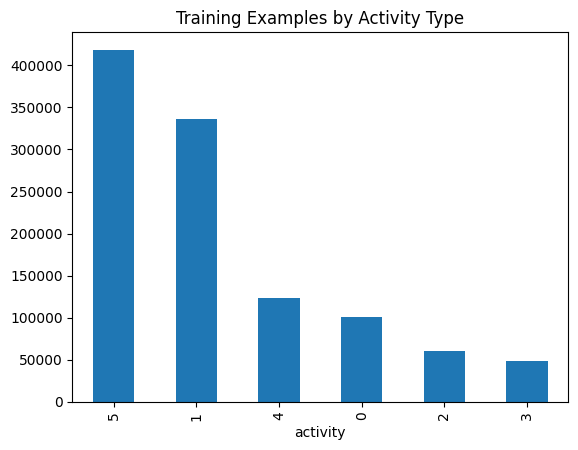

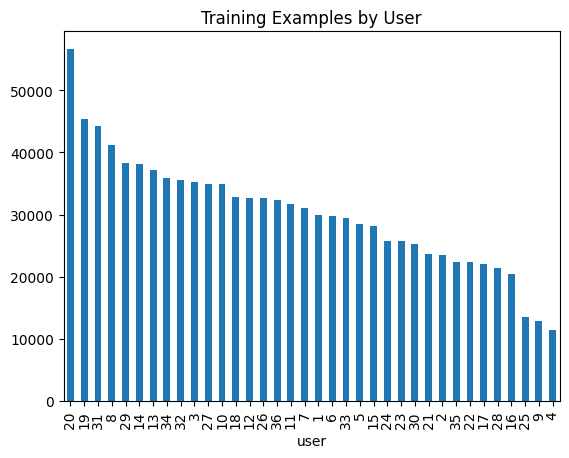

In [146]:
# Show how many training examples exist for each of the six activities
df["activity"].value_counts().plot(kind = "bar", title = "Training Examples by Activity Type")
plt.show()
# Better understand how the recordings are spread across the different users who participated in the study
df["user"].value_counts().plot(kind = "bar", title = "Training Examples by User")
plt.show()

In [147]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [148]:
users=sorted(df['user'].unique())
print(users)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [149]:
#train, test 분리
train_users=[u for u in users if u<=28]
val_users=[u for u in users if 2832]
test_users=[u for u in users if u>32]

#사용자 그룹에 따라 DataFrame 생성
train_df = df[df['user'].isin(train_users)].copy()
test_df  = df[df['user'].isin(test_users)].copy()
val_df=df[df['user'].isin(val_users)].copy()

# NaN 값 제거
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()


print("======데이터 분할(사용자 기반)=====")
print(f"훈련용 사용자 수: {len(train_users)}명, 데이터 수: {len(train_df)}")
print(f"검증용 사용자 수: {len(val_users)}명, 데이터 수: {len(val_df)}")
print(f"테스트용 사용자 수: {len(test_users)}명, 데이터 수: {len(test_df)}")

======데이터 분할(사용자 기반)=====
훈련용 사용자 수: 28명, 데이터 수: 823043
검증용 사용자 수: 36명, 데이터 수: 1086465
테스트용 사용자 수: 4명, 데이터 수: 120055


In [150]:
from sklearn.preprocessing import StandardScaler

# Define the features to be scaled
features = ['x', 'y', 'z']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform all dataframes
scaler.fit(train_df[features])        # 훈련 데이터로만 학습
train_df[features] = scaler.transform(train_df[features])  # 동일 기준 적용
val_df[features] = scaler.transform(val_df[features])      # 동일 기준 적용
test_df[features] = scaler.transform(test_df[features])    # 동일 기준 적용

print("데이터 스케일링 완료")

데이터 스케일링 완료


In [151]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]

        win_labels = df[label_name].values[i:i+time_steps].astype(int)
        label = np.bincount(win_labels).argmax()
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [152]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activity'

In [153]:
# Check for NaN values before segmentation
print("Checking for NaN values in dataframes before segmentation:")
print(f"train_df contains NaN: {train_df.isnull().values.any()}")
print(f"val_df contains NaN: {val_df.isnull().values.any()}")
print(f"test_df contains NaN: {test_df.isnull().values.any()}")
print("====================================")

# Ensure no NaN values before segmentation
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

# Check for NaN values after dropping
print("Checking for NaN values in dataframes after dropping:")
print(f"train_df contains NaN: {train_df.isnull().values.any()}")
print(f"val_df contains NaN: {val_df.isnull().values.any()}")
print(f"test_df contains NaN: {test_df.isnull().values.any()}")
print("====================================")


#훈련 데이터셋
x_train, y_train=segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#검증 데이터셋
x_val, y_val=segments(val_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#테스트 데이터셋
x_test, y_test=segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#원핫인코딩
from tensorflow.keras.utils import to_categorical

num_classes=label.classes_.size
y_train_hot=to_categorical(y_train, num_classes)
y_val_hot=to_categorical(y_val, num_classes)
y_test_hot=to_categorical(y_test, num_classes)

# x_train = x_train / np.max(np.abs(x_train)) # 이 부분 제거
# x_val = x_val / np.max(np.abs(x_val)) # 이 부분 제거

print("훈련 데이터:", x_train.shape, y_train_hot.shape)
print("검증 데이터", x_val.shape, y_val_hot.shape)

print("====================================")

x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, 3, 1)
x_val = x_val.reshape(x_val.shape[0], TIME_PERIOD, 3, 1)
x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, 3, 1)

x_train.shape, x_val.shape

Checking for NaN values in dataframes before segmentation:
train_df contains NaN: False
val_df contains NaN: False
test_df contains NaN: False
Checking for NaN values in dataframes after dropping:
train_df contains NaN: False
val_df contains NaN: False
test_df contains NaN: False
훈련 데이터: (20575, 80, 3) (20575, 6)
검증 데이터 (27160, 80, 3) (27160, 6)


((20575, 80, 3, 1), (27160, 80, 3, 1))

### CNN + Transformer 하이브리드 모델 구현

    Transformer Encoder 블록 구현
    
    Args:
        inputs: 입력 텐서 [batch, sequence, features]
        num_heads: Multi-Head Attention의 헤드 개수
        key_dim: 각 어텐션 헤드의 차원 크기
        ff_dim: Feed-Forward Network의 내부 유닛 수
        dropout_rate: 드롭아웃 비율 (기본값: 0.1)
    
    Returns:
        out2: 트랜스포머 인코더 출력 텐서
    
    핵심 구조:
        1. Multi-Head Self-Attention
        2. Residual Connection + Layer Normalization  
        3. Feed-Forward Network
        4. Residual Connection + Layer Normalization

In [154]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Reshape,
                                     Dense, Dropout, GlobalAveragePooling1D,
                                     MultiHeadAttention, LayerNormalization, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def transformer_encoder_block(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.1):
    # Multi-Head Self Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    out1 = Add()([inputs, attention_output])
    out1 = LayerNormalization(epsilon=1e-4)(out1)

    # Feed Forward Network
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = Add()([out1, ffn_output])
    out2 = LayerNormalization(epsilon=1e-4)(out2)
    return out2

### CNN + Transformer 하이브리드 모델 생성 함수

CNN과 Transformer를 결합한 HAR 모델 생성
    
    Args:
        input_shape: 입력 데이터 형태 (time_steps, features, 1)
        num_classes: 분류할 클래스 개수
        num_transformer_blocks: 트랜스포머 인코더 블록 개수 (기본값: 1)
        num_heads: Multi-Head Attention의 헤드 개수 (기본값: 4)
        ff_dim: Feed-Forward Network의 내부 유닛 수 (기본값: 64)
        cnn_filters: CNN 필터 개수 (기본값: 32)
        dropout_rate: 드롭아웃 비율 (기본값: 0.4)
    
    Returns:
        model: 컴파일된 Keras 모델
    
    모델 구조:
        1. CNN 특징 추출 레이어 (공간적 패턴 학습)
        2. 형태 변환 (Transformer 입력 형태로)
        3. Transformer Encoder 블록들 (시간적 의존성 학습)
        4. 분류 헤드 (최종 예측)

In [155]:
def create_cnn_transformer(input_shape, num_classes,
                           num_transformer_blocks=1, num_heads=4,
                           ff_dim=64, cnn_filters=32, dropout_rate=0.2):
    inputs = Input(shape=input_shape)

    # CNN feature extraction
    x = Conv2D(cnn_filters, (3, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(cnn_filters, (3, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    # Flatten to (batch, time_steps, features)
    time_steps = input_shape[0]
    features = input_shape[1]
    x = Reshape((time_steps, features * cnn_filters))(x)

    # Transformer blocks
    key_dim = min(32, (features * cnn_filters) // num_heads)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_block(x, num_heads, key_dim, ff_dim, dropout_rate)

    # Classification head
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### 모델 생성 및 컴파일

In [156]:

#모델 생성
input_shape=x_train.shape[1:]
num_classes=y_train_hot.shape[1]

model=create_cnn_transformer(
    input_shape,
    num_classes,
    num_transformer_blocks=1,
    num_heads=4,
    ff_dim=64,
    cnn_filters=32,
    dropout_rate=0.4
)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 모델 구조 요약 출력
print("=" * 60)
print("CNN + Transformer 모델 구조")
print("=" * 60)
model.summary()
print("=" * 60)
print(f"총 파라미터 수: {model.count_params():,}")
print(f"입력 형태: {input_shape}")
print(f"출력 클래스 수: {num_classes}")
print("=" * 60)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 80, 3, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 80, 3, 32) │        128 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 32) │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 80, 3, 32) │      3,104 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 32) │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 80, 96)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 80, 96)    │     37,248 │ reshape_12[0][0], │
│ (MultiHeadAttentio… │                   │            │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 80, 96)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 80, 96)    │          0 │ reshape_12[0][0], │
│                     │                   │            │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 96)    │        192 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 80, 64)    │      6,208 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 80, 96)    │      6,240 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 80, 96)    │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 80, 96)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_46[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 96)    │        192 │ add_23[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 96)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 96)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 6)         │        582 │ dropout_47[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 54,150 (211.52 KB)

 Trainable params: 54,022 (211.02 KB)

 Non-trainable params: 128 (512.00 B)

CNN + Transformer 모델 구조


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 80, 3, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 80, 3, 32) │        128 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 32) │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 80, 3, 32) │      3,104 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 32) │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 80, 96)    │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 80, 96)    │     37,248 │ reshape_12[0][0], │
│ (MultiHeadAttentio… │                   │            │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 80, 96)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 80, 96)    │          0 │ reshape_12[0][0], │
│                     │                   │            │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 96)    │        192 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 80, 64)    │      6,208 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 80, 96)    │      6,240 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 80, 96)    │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 80, 96)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_46[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 80, 96)    │        192 │ add_23[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 96)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 96)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 6)         │        582 │ dropout_47[0][0]  │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 54,150 (211.52 KB)

 Trainable params: 54,022 (211.02 KB)

 Non-trainable params: 128 (512.00 B)

총 파라미터 수: 54,150
입력 형태: (80, 3, 1)
출력 클래스 수: 6


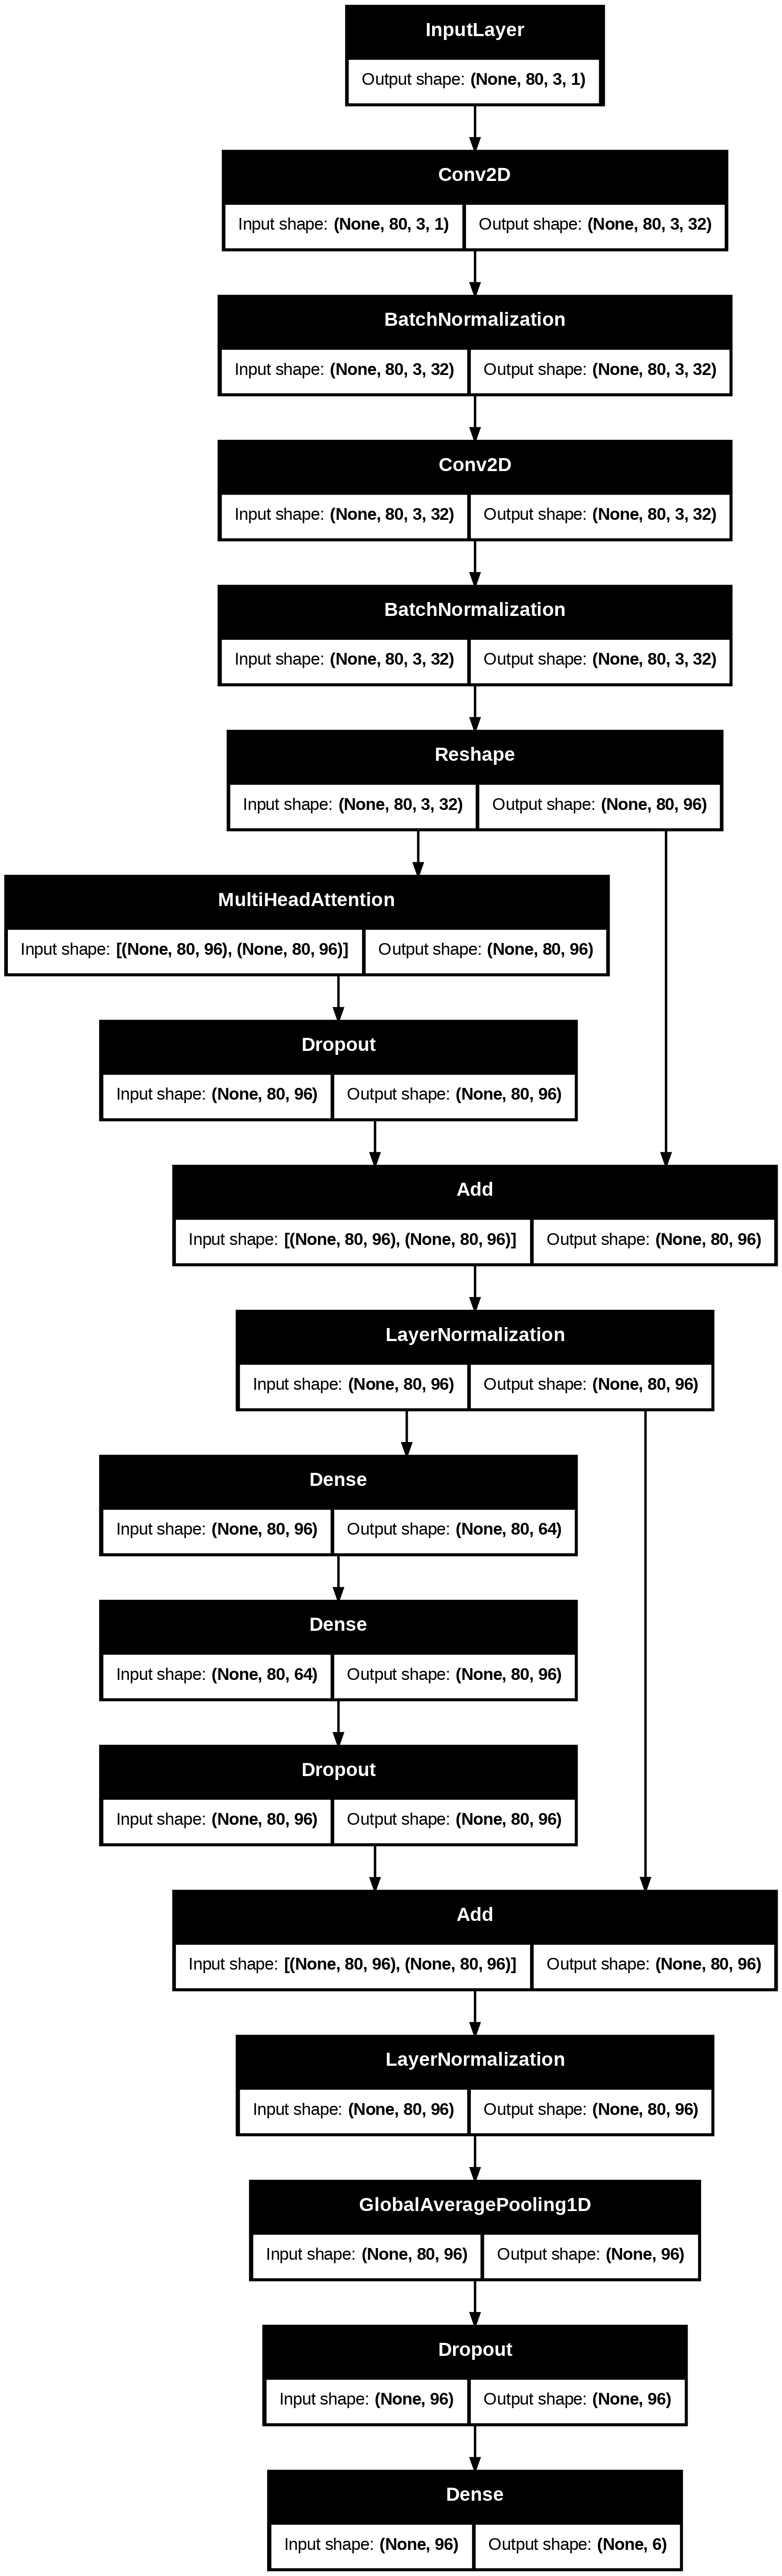

In [157]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [158]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model = create_cnn_transformer(input_shape=(80,3,1), num_classes=6)
model.compile(optimizer=Adam(learning_rate=0.0001), # 학습률 감소
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    x_train, y_train_hot,
    epochs=100,
    batch_size=64,
    validation_data=(x_val, y_val_hot),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.6365 - loss: 1.0641 - val_accuracy: 0.5516 - val_loss: 1.1499 - learning_rate: 1.0000e-04
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8115 - loss: 0.5452 - val_accuracy: 0.8138 - val_loss: 0.4935 - learning_rate: 1.0000e-04
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8504 - loss: 0.4150 - val_accuracy: 0.8598 - val_loss: 0.3951 - learning_rate: 1.0000e-04
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8813 - loss: 0.3308 - val_accuracy: 0.8781 - val_loss: 0.3654 - learning_rate: 1.0000e-04
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8989 - loss: 0.2873 - val_accuracy: 0.8835 - val_loss: 0.3566 - learning_rate: 1.0000e-04
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9033 - loss: 0.2697 - val_accuracy: 0.8966 - val_loss: 0.3179 - learning_rate: 1.0000e-04
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - 

In [159]:
# 스케일링된 훈련 데이터 (x_train)의 통계 정보 확인
print("x_train descriptive statistics:")
print("Mean:", np.mean(x_train))
print("Standard Deviation:", np.std(x_train))
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

# x_train에 nan 또는 무한대 값이 있는지 확인
print("\nChecking x_train for NaN and Inf values:")
print("Contains NaN:", np.isnan(x_train).any())
print("Contains Inf:", np.isinf(x_train).any())

x_train descriptive statistics:
Mean: -5.122355e-06
Standard Deviation: 1.0000106
Min: -4.1887546
Max: 3.958978

Checking x_train for NaN and Inf values:
Contains NaN: False
Contains Inf: False


In [161]:
# 원-핫 인코딩된 훈련 레이블 (y_train_hot) 확인
print("y_train_hot shape:", y_train_hot.shape)

# y_train_hot에 nan 또는 무한대 값이 있는지 확인
print("\nChecking y_train_hot for NaN and Inf values:")
print("Contains NaN:", np.isnan(y_train_hot).any())
print("Contains Inf:", np.isinf(y_train_hot).any())

# 각 샘플의 레이블 합계 확인 (원-핫 인코딩 확인)
print("\nChecking sum of each row in y_train_hot:")
row_sums = np.sum(y_train_hot, axis=1)
print("All row sums are 1:", np.all(row_sums == 1))
print("Unique row sums:", np.unique(row_sums))

# y_train_hot의 값 범위 확인
print("\ny_train_hot value range:")
print("Min value:", np.min(y_train_hot))
print("Max value:", np.max(y_train_hot))

y_train_hot shape: (20575, 6)

Checking y_train_hot for NaN and Inf values:
Contains NaN: False
Contains Inf: False

Checking sum of each row in y_train_hot:
All row sums are 1: True
Unique row sums: [1.]

y_train_hot value range:
Min value: 0.0
Max value: 1.0


In [160]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

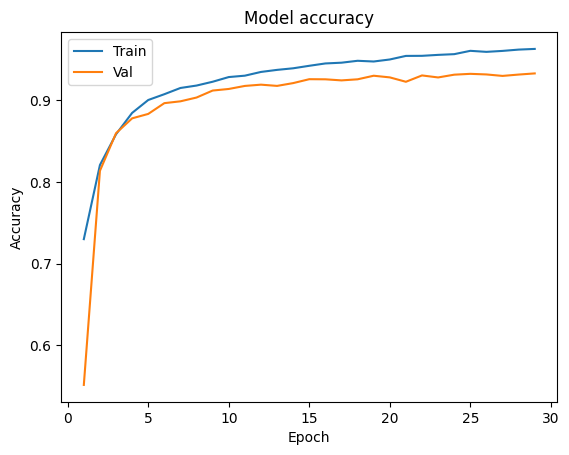

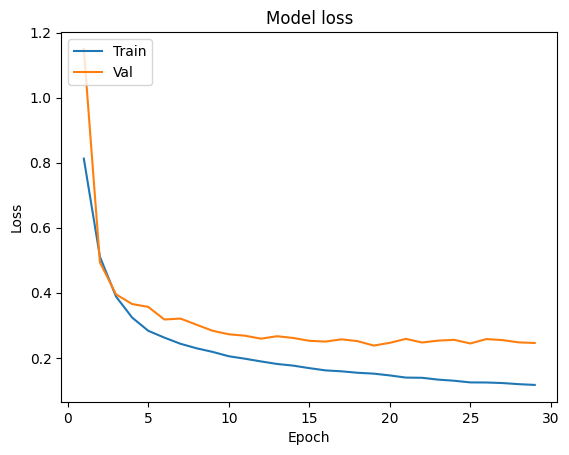

In [162]:
plot_learningCurve(history, len(history.history['accuracy']))

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


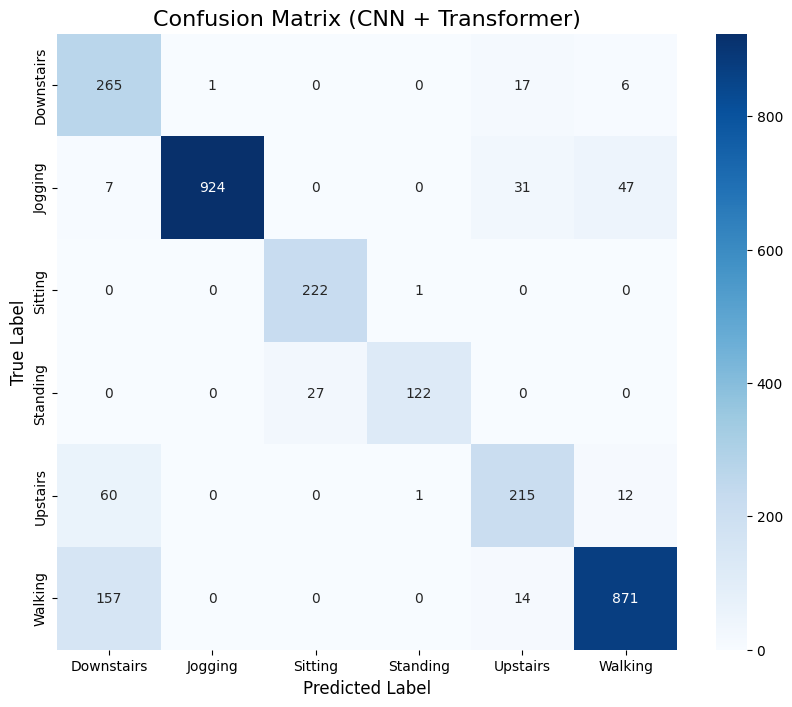

In [163]:

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)
plt.title('Confusion Matrix (CNN + Transformer)', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [164]:

loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)


테스트 데이터 정확도 (Accuracy): 0.8730
테스트 데이터 손실 (Loss): 0.5323


In [165]:
from sklearn.metrics import classification_report

print("\n===== 분류 리포트 (CNN + Transformer) =====")
print(classification_report(y_test, y_pred, target_names=label.classes_))


===== 분류 리포트 (CNN + Transformer) =====
              precision    recall  f1-score   support

  Downstairs       0.54      0.92      0.68       289
     Jogging       1.00      0.92      0.96      1009
     Sitting       0.89      1.00      0.94       223
    Standing       0.98      0.82      0.89       149
    Upstairs       0.78      0.75      0.76       288
     Walking       0.93      0.84      0.88      1042

    accuracy                           0.87      3000
   macro avg       0.85      0.87      0.85      3000
weighted avg       0.90      0.87      0.88      3000

